In [1]:
import sys
sys.path.append("../")

In [2]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch

In [3]:
! export PYTORCH_ENABLE_MPS_FALLBACK=1

In [4]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

In [5]:
mps_device = torch.device("mps")
torch.set_default_device(mps_device)

# Format input data

In [119]:
patient = 'R319'
PATH = "../../Data/echidna3/"
path = os.path.join(PATH, patient + "_tumors.h5ad")
print(path)

../../Data/echidna3/R319_tumors.h5ad


In [120]:
w_path = os.path.join(PATH, "all_cellranger_w.csv")
w_path

'../../Data/echidna3/all_cellranger_w.csv'

In [121]:
from echidna.utils import *

In [122]:
W = read_W(w_path)

In [123]:
X = sc.read_h5ad(path)
X

AnnData object with n_obs × n_vars = 14909 × 22609
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'percent.rp', 'sample', 'patient', 'condition', 'barcode_orig', 'barcode_pat', 'samples_per_patient', 'timepoint', 'Before.During.After', 'Sample_J', 'Gender', 'Treatment_phase', 'Drug', 'tissue', 'Mutation', 'sample_group', 'predicted_doublets', 'doublet_scores', 'RNA_snn_res.0.8', 'seurat_clusters', 'clonotype_id', 'chain', 'v_gene', 'd_gene', 'j_gene', 'c_gene', 'frequency', 'proportion', 'cdr3s_aa', 'cdr3s_nt', 'inkt_evidence', 'mait_evidence', 'tcr', 'mait', 'inkt', 'both_chains', 'clone_size', 'mait_inkt', 'celltype_bped_main', 'celltype_bped_fine', 'celltype_hpca_main', 'celltype_hpca_fine', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_origi

/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


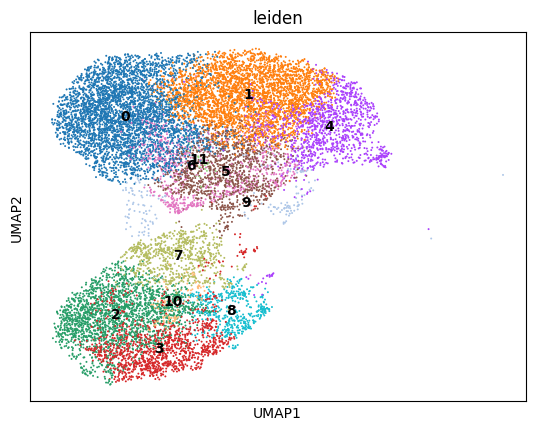

In [124]:
sc.pl.umap(X, color=['leiden'], legend_loc='on data')

In [126]:
X_obs, W_obs, z_obs, pi_obs = prepare_input(X, W, sample_name=patient, 
                                            timepoints=['on', 'pre'], n_subsamples=3000, device="cpu")
print(X_obs.shape)
print(W_obs.shape)
print(z_obs.shape)
print(pi_obs.shape)

torch.Size([2, 3000, 22609])
torch.Size([2, 22609])
torch.Size([2, 3000])
torch.Size([2, 12])


# Train model

In [127]:
from echidna.model import Echidna
from echidna.train import train_Echidna
from echidna.utils import ModelConfig
from echidna.eval import get_learned_params

In [128]:
config = ModelConfig()
config.num_cells = X_obs.shape[1]
config.num_genes = X_obs.shape[-1]
config.num_timepoints = X_obs.shape[0]
config.num_clusters = pi_obs.shape[-1]
config.q_corr_init = 1e-2
config.q_shape_rate_scaler = 10.0

In [129]:
echidna = Echidna(config, mode="MT", device="cpu")

In [130]:
echidna, loss = train_Echidna(echidna, X_obs, W_obs, pi_obs, z_obs, lr=0.1, n_epochs=1000)

100%|██████████| 1000/1000 [07:49<00:00,  2.13it/s]


In [131]:
params = get_learned_params(echidna, X_obs, W_obs, pi_obs, z_obs)

# Look at trained model

In [132]:
import torch.nn.functional as F
from echidna.eval import sample_W, sample_X, plot_true_vs_pred, sample_C
import seaborn as sns
import matplotlib.pyplot as plt

In [133]:
params.keys()

odict_keys(['_INPUT', 'G:genes', 'K:clusters', 'scale', 'cholesky_corr', 'eta', 'genes', 'timepoints_w', 'W', 'timepoints_c', 'c', 'X_0', 'X_1', '_RETURN'])

In [134]:
eta = F.softplus(params['eta']['value'].T)
c_on = params['c']['value'][0, :, :]
c_pre = params['c']['value'][1, :, :]
c_shape = pyro.param('c_shape')
lib_on = X_obs[0, :, :].sum(-1, keepdim=True) * 1e-5
lib_pre = X_obs[1, :, :].sum(-1, keepdim=True) * 1e-5
z_on = z_obs[0, :]
z_pre = z_obs[1, :]

In [135]:
X_learned_on = sample_X(X_obs.numpy(), c_on, eta, z_on.numpy(), lib_on)
X_learned_pre = sample_X(X_obs.numpy(), c_pre, eta, z_pre.numpy(), lib_on)

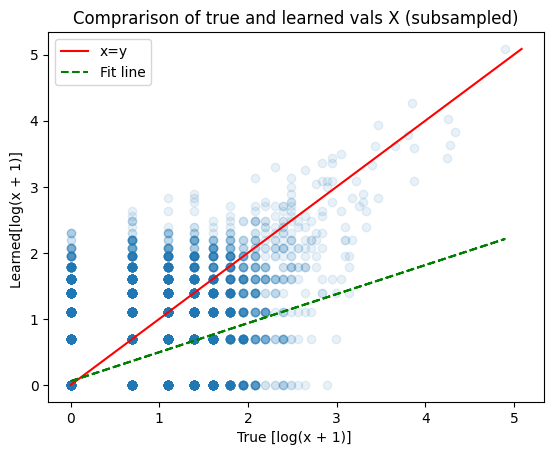

In [136]:
plot_true_vs_pred(X_learned_on, X_obs[0, :, :].numpy(), log_scale=True, name='X')

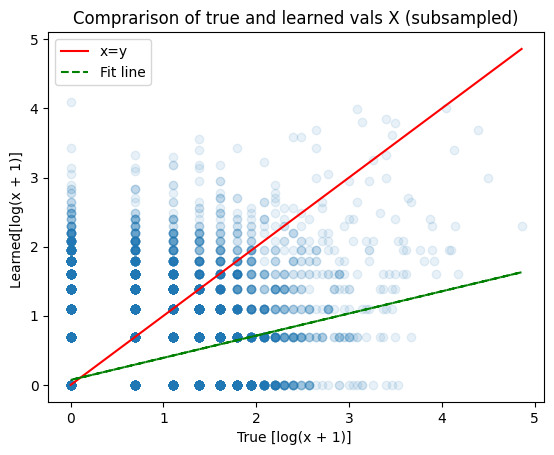

In [137]:
plot_true_vs_pred(X_learned_pre, X_obs[-1, :, :].numpy(), log_scale=True, name='X')

In [138]:
W_learned = np.array(sample_W(pi_obs, eta))
W_obs_np = W_obs.numpy()

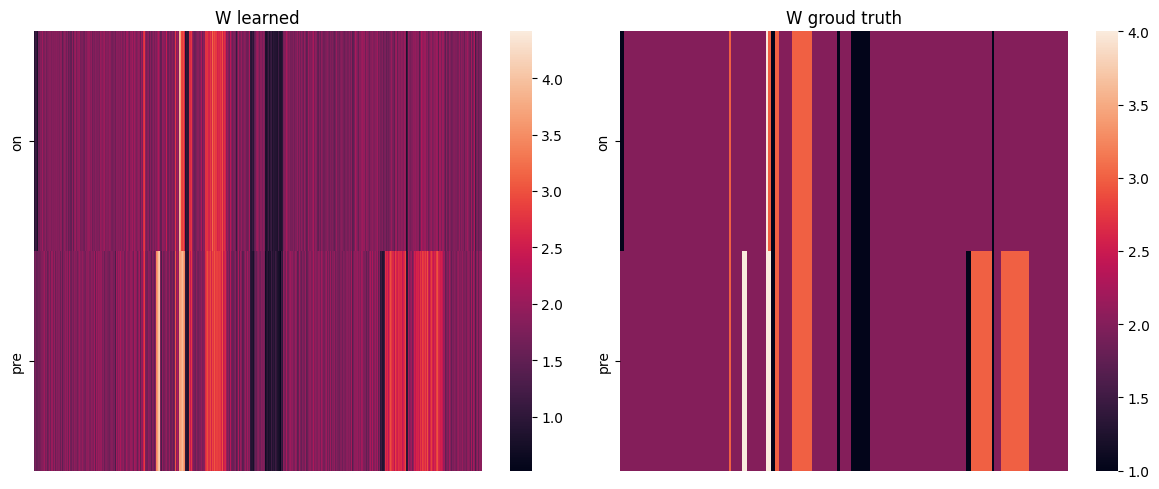

In [139]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first heatmap
sns.heatmap(W_learned, ax=axes[0])
axes[0].set_title('W learned')
axes[0].set_xticks([])
axes[0].set_yticklabels(['on', 'pre'])

# Plot the second heatmap
sns.heatmap(W_obs_np, ax=axes[1])
axes[1].set_title("W groud truth")
axes[1].set_xticks([])
axes[1].set_yticklabels(['on', 'pre'])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 100x100 with 0 Axes>

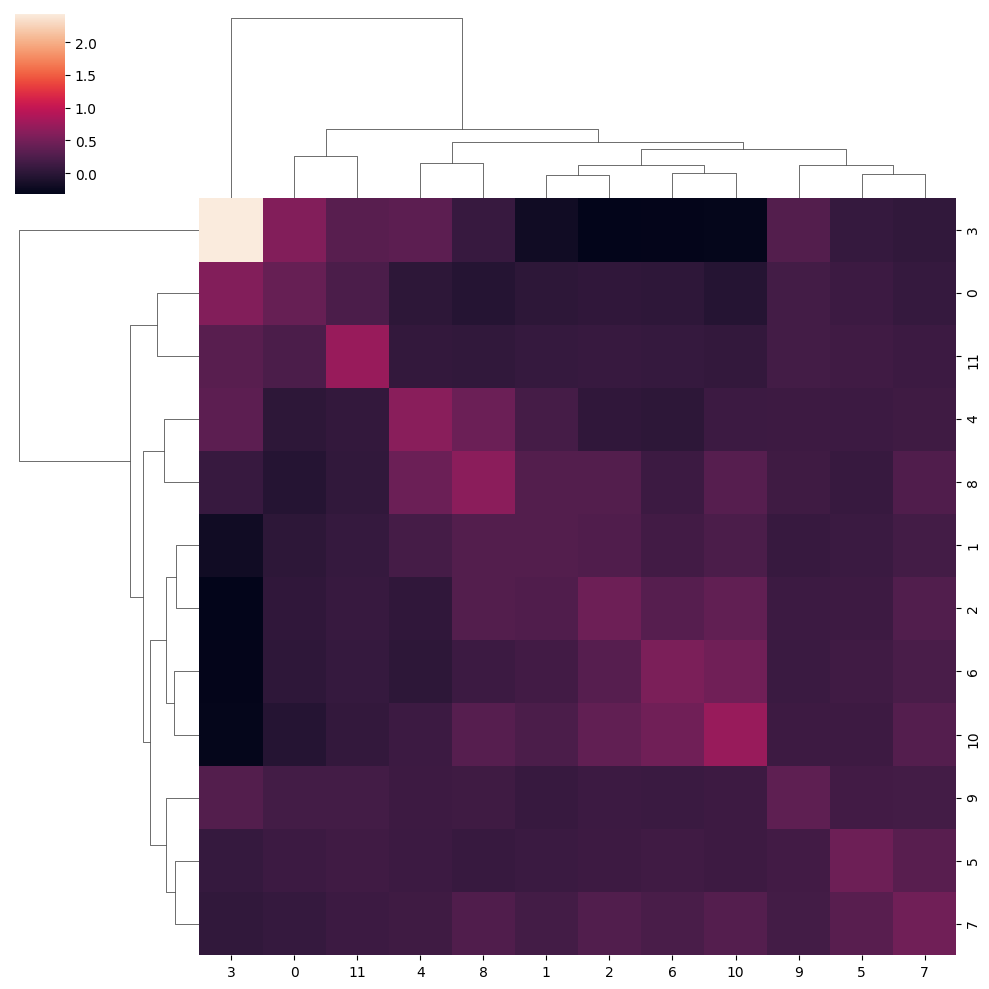

In [140]:
plt.figure(figsize=(1, 1)) 
sns.clustermap(torch.cov(eta).cpu().detach().numpy())
plt.show()

In [141]:
from echidna.eval import eta_cov_tree, assign_clones, learned_cov

In [142]:
params.keys()

odict_keys(['_INPUT', 'G:genes', 'K:clusters', 'scale', 'cholesky_corr', 'eta', 'genes', 'timepoints_w', 'W', 'timepoints_c', 'c', 'X_0', 'X_1', '_RETURN'])

In [143]:
L = params['cholesky_corr']['value']
scale = params['scale']['value']

In [144]:
cov = learned_cov(L, scale)

/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


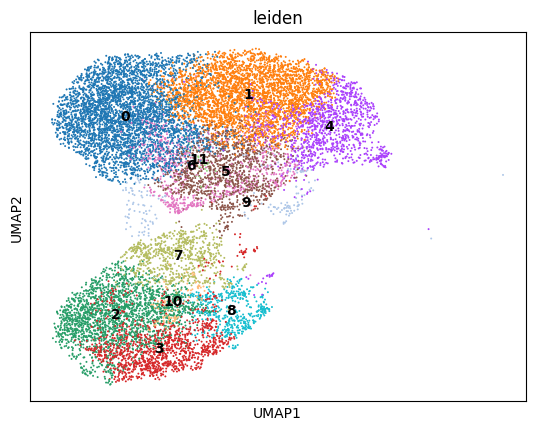

In [145]:
sc.pl.umap(X, color=['leiden'], legend_loc='on data')

In [146]:
from echidna.eval import eta_cov_tree_elbow_thresholding, eta_cov_tree

Knee point:  10
Threshold:  1.027733342780677


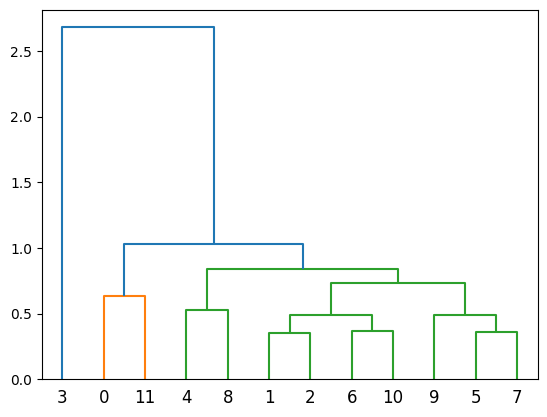

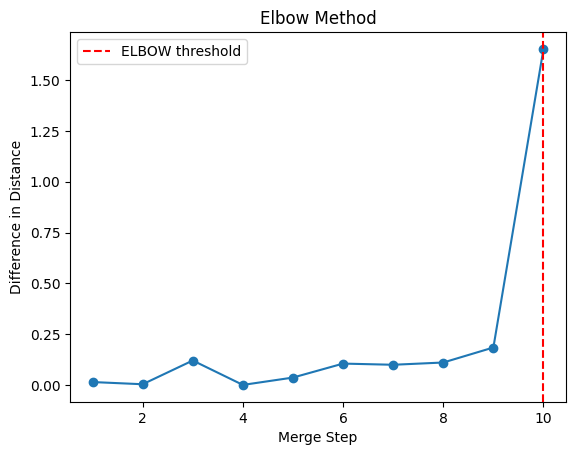

In [147]:
dn = eta_cov_tree_elbow_thresholding(eta, plot_elbow=True)

In [148]:
assign_clones(eta, dn, X)

/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


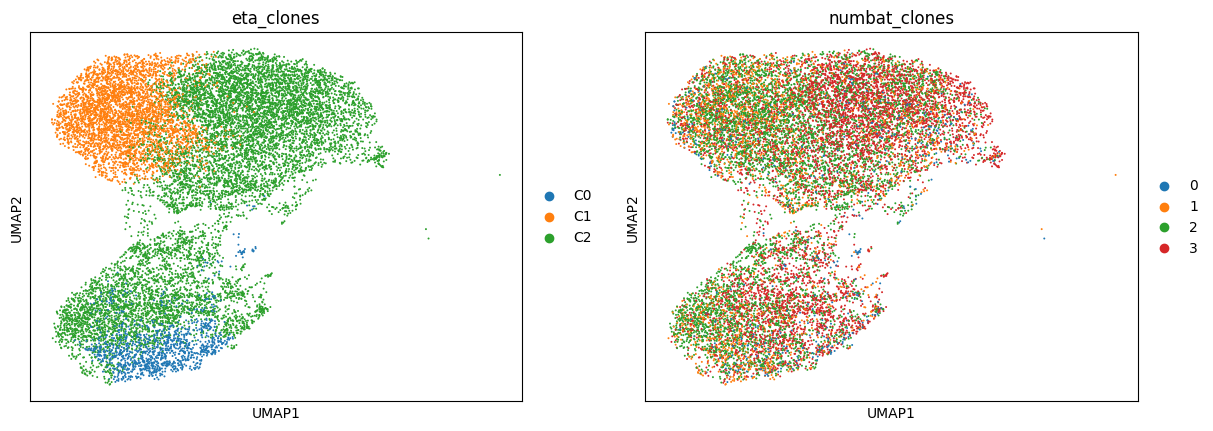

In [149]:
sc.pl.umap(X, color=['eta_clones', 'numbat_clones'])